# 06_results_comparison.ipynb

In [1]:
# Model Results Visualization
# This notebook loads and visualizes results from trained models stored as .pth files

import os
import glob
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display, HTML
import ipywidgets as widgets
from torch.serialization import add_safe_globals

In [2]:
# Set paths
MODEL_DIR = "../models"
OUTPUT_DIR = "../data/processed"

In [3]:
# Load class mappings
with open(os.path.join(OUTPUT_DIR, "class_mappings.json"), "r") as f:
    mappings = json.load(f)
    class_to_idx = mappings["class_to_idx"]
    idx_to_class = {int(k): v for k, v in mappings["idx_to_class"].items()}

In [4]:
# Get all model files
model_files = glob.glob(os.path.join(MODEL_DIR, "*.pth"))
print(f"Found {len(model_files)} model files")

Found 19 model files


In [5]:
# Register numpy scalar as a safe global to allow loading numpy data in PyTorch 2.6+
# Only do this with files you trust as it could potentially be a security risk
try:
    add_safe_globals([np.core.multiarray.scalar])
    print("Added numpy.core.multiarray.scalar to PyTorch safe globals list")
except Exception as e:
    print(f"Warning: Could not add numpy scalar to safe globals: {e}")

Added numpy.core.multiarray.scalar to PyTorch safe globals list


In [6]:
# Function to extract key information from model files
def extract_model_info(model_path):
    """Extract key information from a saved model file"""
    try:
        # Add safe_globals to handle numpy scalar serialization issue
        import numpy as np
        from torch.serialization import safe_globals
        
        # Using a context manager to safely load numpy arrays - only do this with files you trust!
        with safe_globals([np.core.multiarray.scalar]):
            # Load with weights_only=False since we need to access the full dictionary
            checkpoint = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
        
        # Extract basic model info
        model_info = {
            'filename': os.path.basename(model_path),
            'model_name': checkpoint.get('model_name', 'unknown'),
            'freeze_backbone': checkpoint.get('freeze_backbone', None),
            'backbone_status': 'frozen' if checkpoint.get('freeze_backbone', False) else 'unfrozen',
            'test_accuracy': checkpoint.get('test_accuracy', None),
            'num_epochs': checkpoint.get('num_epochs', None),
            'timestamp': checkpoint.get('timestamp', '')
        }
        
        # Extract training history if available
        history = checkpoint.get('history', {})
        if history:
            # Extract final metrics
            model_info['final_train_loss'] = history.get('train_loss', [])[-1] if history.get('train_loss', []) else None
            model_info['final_val_loss'] = history.get('val_loss', [])[-1] if history.get('val_loss', []) else None
            model_info['final_train_acc'] = history.get('train_acc', [])[-1] if history.get('train_acc', []) else None
            model_info['final_val_acc'] = history.get('val_acc', [])[-1] if history.get('val_acc', []) else None
            
            # Extract best validation accuracy
            if history.get('val_acc', []):
                model_info['best_val_acc'] = max(history.get('val_acc', []))
            else:
                model_info['best_val_acc'] = None
                
            # Extract total epochs trained
            model_info['epochs_completed'] = history.get('epochs_completed', len(history.get('train_loss', [])))
            
            # Check if early stopping was triggered
            model_info['early_stopped'] = history.get('early_stopped', False)
            
            # Store full history
            model_info['history'] = history
        
        return model_info
    
    except Exception as e:
        print(f"Error loading {model_path}: {e}")
        return {
            'filename': os.path.basename(model_path),
            'error': str(e)
        }

In [7]:
# Extract information from all model files
model_results = [extract_model_info(path) for path in model_files]

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(model_results)

In [8]:
# Display summary table
if not df_results.empty:
    # Select and order columns for display
    display_cols = ['filename', 'model_name', 'backbone_status', 'best_val_acc', 
                'test_accuracy', 'epochs_completed', 'early_stopped', 'timestamp']
    
    # Filter out columns that don't exist in the dataframe
    display_cols = [col for col in display_cols if col in df_results.columns]
    
    display_df = df_results[display_cols].copy()
    
    # Format accuracy values
    for col in ['best_val_acc', 'test_accuracy']:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}" if pd.notnull(x) else "N/A")
    
    # Show the summary table
    print("\n=== Model Results Summary ===")
    display(display_df)
else:
    print("No valid model results found.")


=== Model Results Summary ===


,filename,model_name,backbone_status,best_val_acc,test_accuracy,epochs_completed,early_stopped,timestamp
0,efficientnet_b0_frozen.pth,efficientnet_b0,frozen,N/A,N/A,NaN,NaN,
1,efficientnet_b0_frozen_20250406_1628.pth,efficientnet_b0,frozen,0.7773,0.7716,16.0,True,20250406_1628
2,efficientnet_b0_unfrozen_20250406_1802.pth,efficientnet_b0,unfrozen,0.9859,0.9827,25.0,False,20250406_1802
3,efficientnet_b4_frozen.pth,efficientnet_b4,frozen,N/A,N/A,NaN,NaN,
4,efficientnet_b4_frozen_20250410_1203.pth,efficientnet_b4,frozen,0.6995,0.6948,16.0,True,20250410_1203
5,efficientnet_b4_unfrozen_20250410_1507.pth,efficientnet_b4,unfrozen,0.9802,0.9783,18.0,True,20250410_1507
6,resnet18_frozen.pth,resnet18,frozen,N/A,N/A,NaN,NaN,
7,resnet18_frozen_20250320_1300.pth,resnet18,frozen,0.8306,N/A,25.0,False,
8,resnet18_frozen_20250404_1449.pth,resnet18,frozen,0.8188,N/A,10.0,False,20250404_1449
9,resnet18_frozen_20250406_1324.pth,resnet18,frozen,0.8217,N/A,10.0,False,


In [9]:
# Function to plot training history for a selected model
def plot_model_history(model_info):
    """Plot training metrics for a selected model"""
    history = model_info.get('history', {})
    
    if not history or not history.get('train_loss'):
        print("No training history available for this model")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training and validation loss
    axes[0].plot(history.get('train_loss', []), label='Training')
    axes[0].plot(history.get('val_loss', []), label='Validation')
    axes[0].set_title(f"Loss Curves - {model_info['model_name']} ({model_info['backbone_status']})")
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Plot training and validation accuracy
    axes[1].plot(history.get('train_acc', []), label='Training')
    axes[1].plot(history.get('val_acc', []), label='Validation')
    axes[1].set_title(f"Accuracy Curves - {model_info['model_name']} ({model_info['backbone_status']})")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

In [10]:
# Function to compare models
def compare_models_by_architecture():
    """Group and compare models by architecture type"""
    if df_results.empty:
        print("No model results to compare")
        return
    
    # Group models by architecture
    grouped = df_results.groupby('model_name')
    
    # For each architecture, compare frozen vs unfrozen
    for name, group in grouped:
        # Skip if only one model of this architecture
        if len(group) < 2:
            continue
            
        # Get best frozen and unfrozen models
        frozen_models = group[group['backbone_status'] == 'frozen']
        unfrozen_models = group[group['backbone_status'] == 'unfrozen']
        
        if frozen_models.empty or unfrozen_models.empty:
            continue
            
        # Use best validation accuracy to select best models
        if 'best_val_acc' in frozen_models.columns:
            best_frozen = frozen_models.loc[frozen_models['best_val_acc'].idxmax()]
            best_unfrozen = unfrozen_models.loc[unfrozen_models['best_val_acc'].idxmax()]
        else:
            # Just take the first one if no accuracy metric
            best_frozen = frozen_models.iloc[0]
            best_unfrozen = unfrozen_models.iloc[0]
        
        print(f"\n=== Comparing {name} Architecture ===")
        print(f"Best frozen model: {best_frozen['filename']}")
        print(f"Best unfrozen model: {best_unfrozen['filename']}")
        
        # Create performance comparison chart
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Extract histories
        frozen_history = best_frozen.get('history', {})
        unfrozen_history = best_unfrozen.get('history', {})
        
        if not frozen_history or not unfrozen_history:
            print("Training history not available for comparison")
            continue
        
        # Plot training loss
        axes[0, 0].plot(frozen_history.get('train_loss', []), label='Frozen')
        axes[0, 0].plot(unfrozen_history.get('train_loss', []), label='Unfrozen')
        axes[0, 0].set_title('Training Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        
        # Plot validation loss
        axes[0, 1].plot(frozen_history.get('val_loss', []), label='Frozen')
        axes[0, 1].plot(unfrozen_history.get('val_loss', []), label='Unfrozen')
        axes[0, 1].set_title('Validation Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        
        # Plot training accuracy
        axes[1, 0].plot(frozen_history.get('train_acc', []), label='Frozen')
        axes[1, 0].plot(unfrozen_history.get('train_acc', []), label='Unfrozen')
        axes[1, 0].set_title('Training Accuracy')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Accuracy')
        axes[1, 0].legend()
        
        # Plot validation accuracy
        axes[1, 1].plot(frozen_history.get('val_acc', []), label='Frozen')
        axes[1, 1].plot(unfrozen_history.get('val_acc', []), label='Unfrozen')
        axes[1, 1].set_title('Validation Accuracy')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print metrics comparison
        print("\nPerformance Metrics:")
        metric_df = pd.DataFrame({
            'Metric': ['Best Validation Accuracy', 'Test Accuracy', 'Epochs Completed'],
            'Frozen': [
                f"{best_frozen.get('best_val_acc', 'N/A'):.4f}" if pd.notnull(best_frozen.get('best_val_acc')) else 'N/A',
                f"{best_frozen.get('test_accuracy', 'N/A'):.4f}" if pd.notnull(best_frozen.get('test_accuracy')) else 'N/A',
                best_frozen.get('epochs_completed', 'N/A')
            ],
            'Unfrozen': [
                f"{best_unfrozen.get('best_val_acc', 'N/A'):.4f}" if pd.notnull(best_unfrozen.get('best_val_acc')) else 'N/A',
                f"{best_unfrozen.get('test_accuracy', 'N/A'):.4f}" if pd.notnull(best_unfrozen.get('test_accuracy')) else 'N/A',
                best_unfrozen.get('epochs_completed', 'N/A')
            ]
        })
        display(metric_df)


=== Comparing efficientnet_b0 Architecture ===
Best frozen model: efficientnet_b0_frozen_20250406_1628.pth
Best unfrozen model: efficientnet_b0_unfrozen_20250406_1802.pth


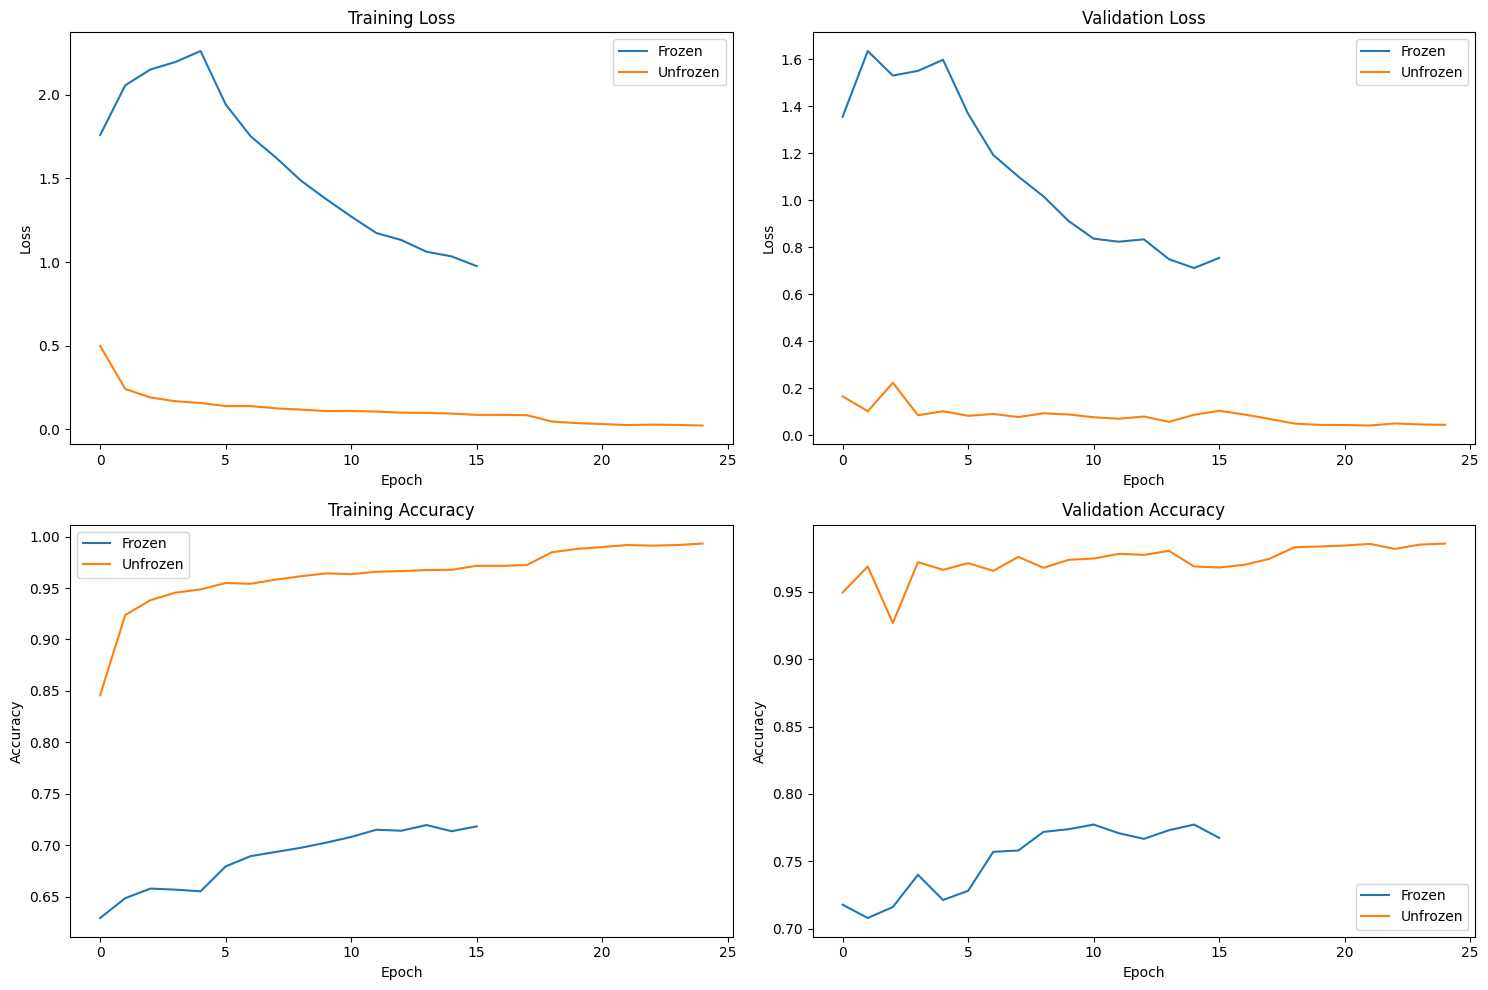


Performance Metrics:


,Metric,Frozen,Unfrozen
0,Best Validation Accuracy,0.7773,0.9859
1,Test Accuracy,0.7716,0.9827
2,Epochs Completed,16.0,25.0



=== Comparing efficientnet_b4 Architecture ===
Best frozen model: efficientnet_b4_frozen_20250410_1203.pth
Best unfrozen model: efficientnet_b4_unfrozen_20250410_1507.pth


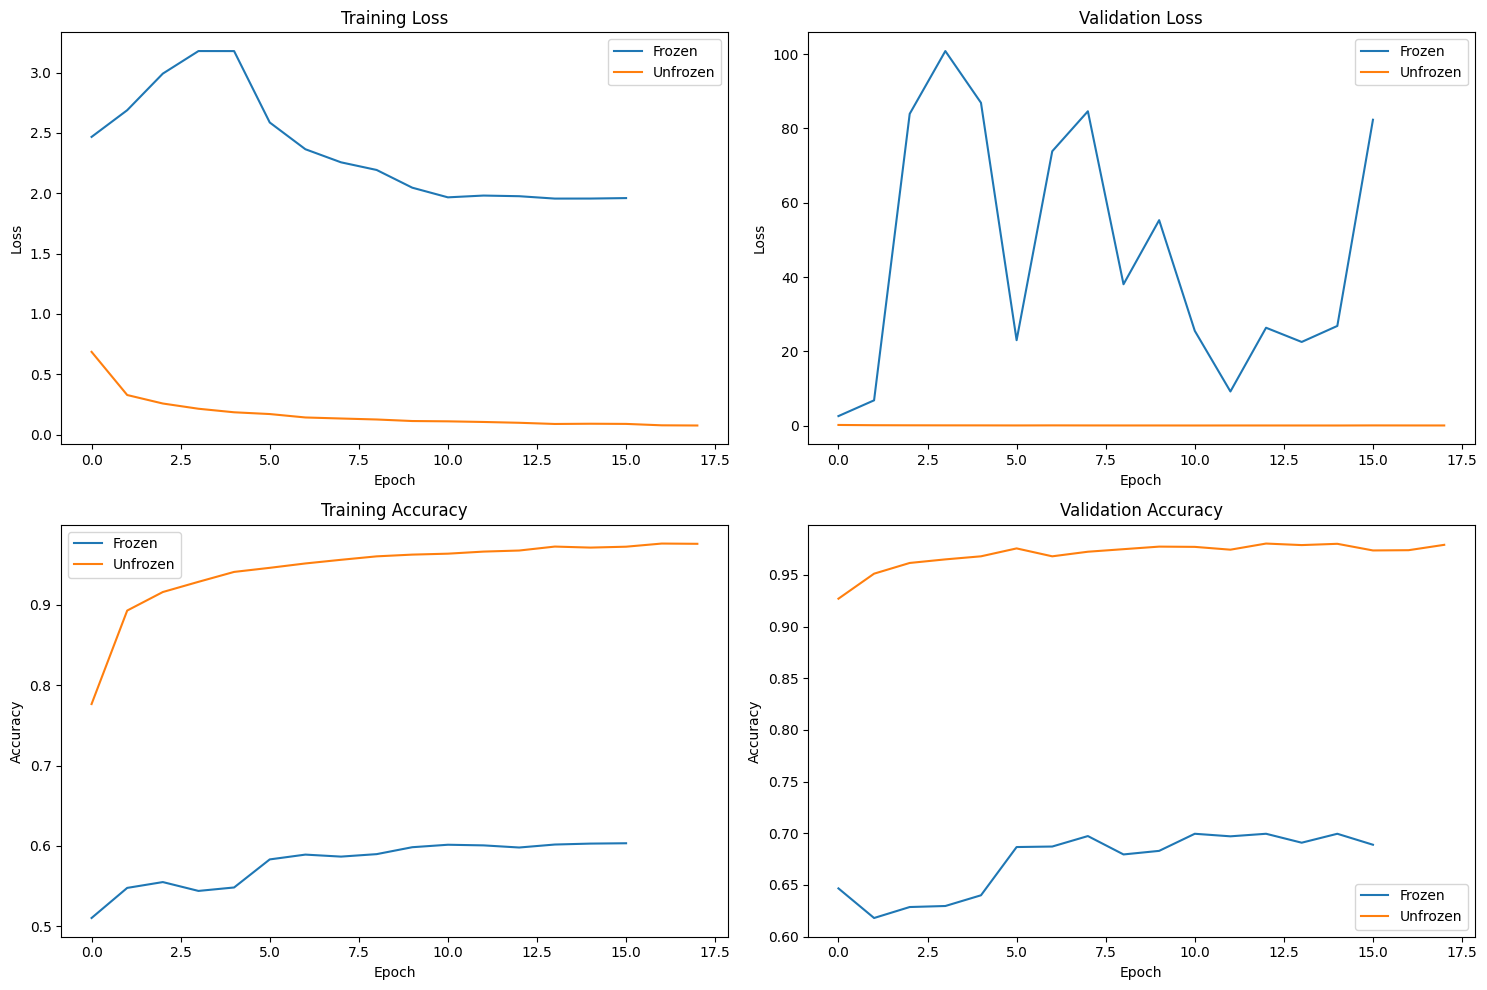


Performance Metrics:


,Metric,Frozen,Unfrozen
0,Best Validation Accuracy,0.6995,0.9802
1,Test Accuracy,0.6948,0.9783
2,Epochs Completed,16.0,18.0



=== Comparing resnet18 Architecture ===
Best frozen model: resnet18_frozen_20250406_1508.pth
Best unfrozen model: resnet18_unfrozen_20250406_1554.pth


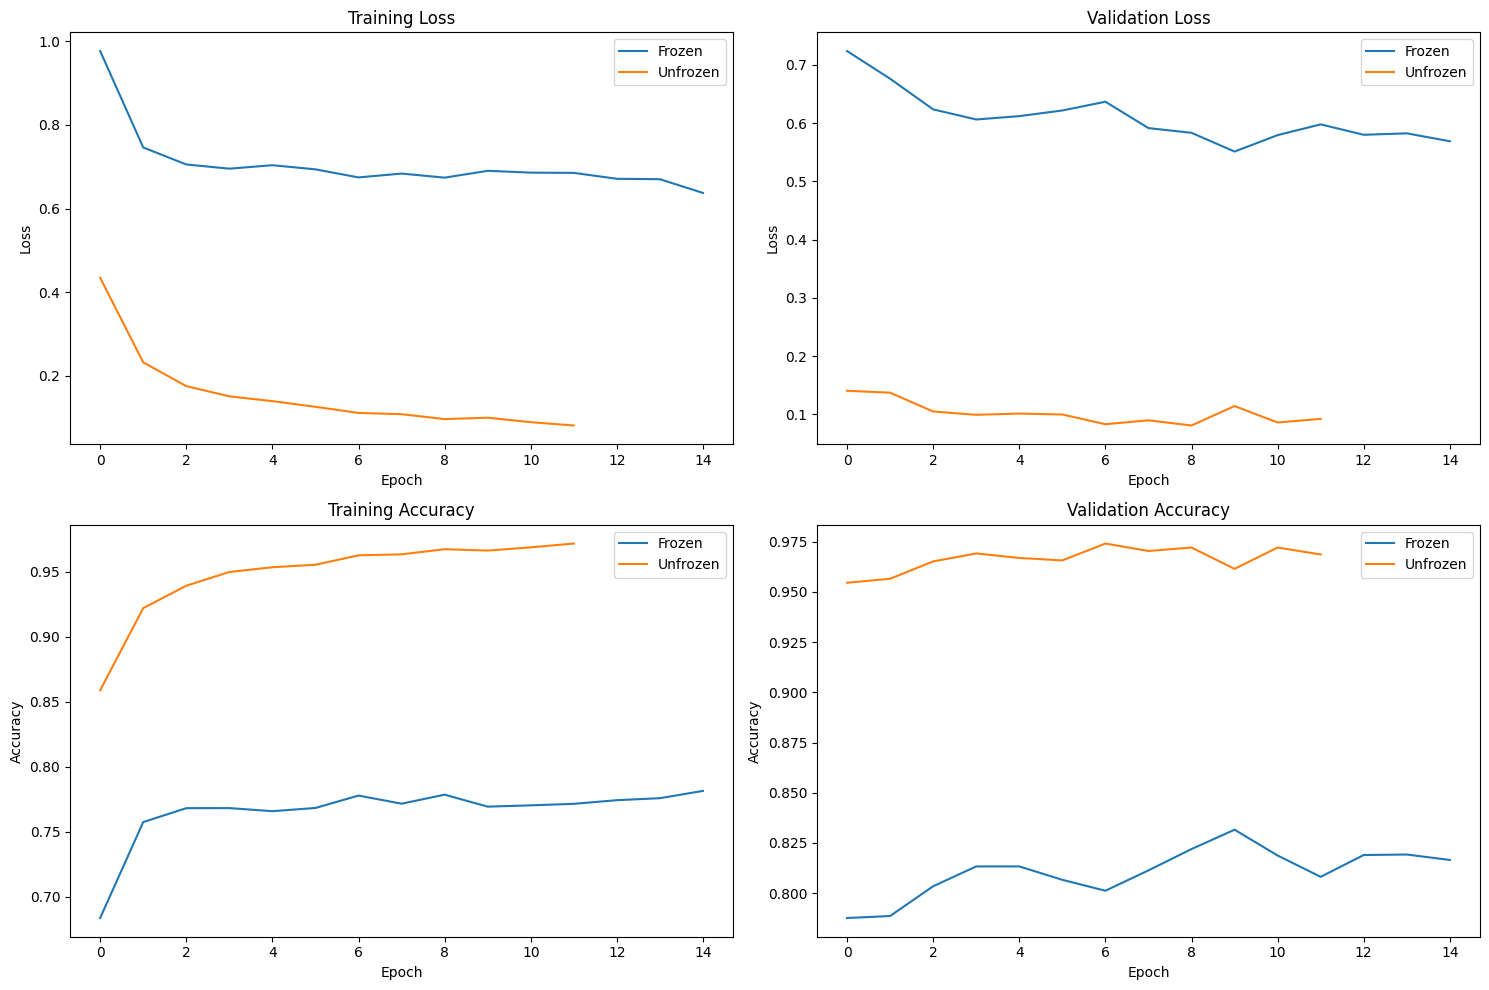


Performance Metrics:


,Metric,Frozen,Unfrozen
0,Best Validation Accuracy,0.8316,0.9741
1,Test Accuracy,0.8232,0.9664
2,Epochs Completed,15.0,12.0



=== Comparing resnet50 Architecture ===
Best frozen model: resnet50_frozen_20250409_1821.pth
Best unfrozen model: resnet50_unfrozen_20250409_2059.pth


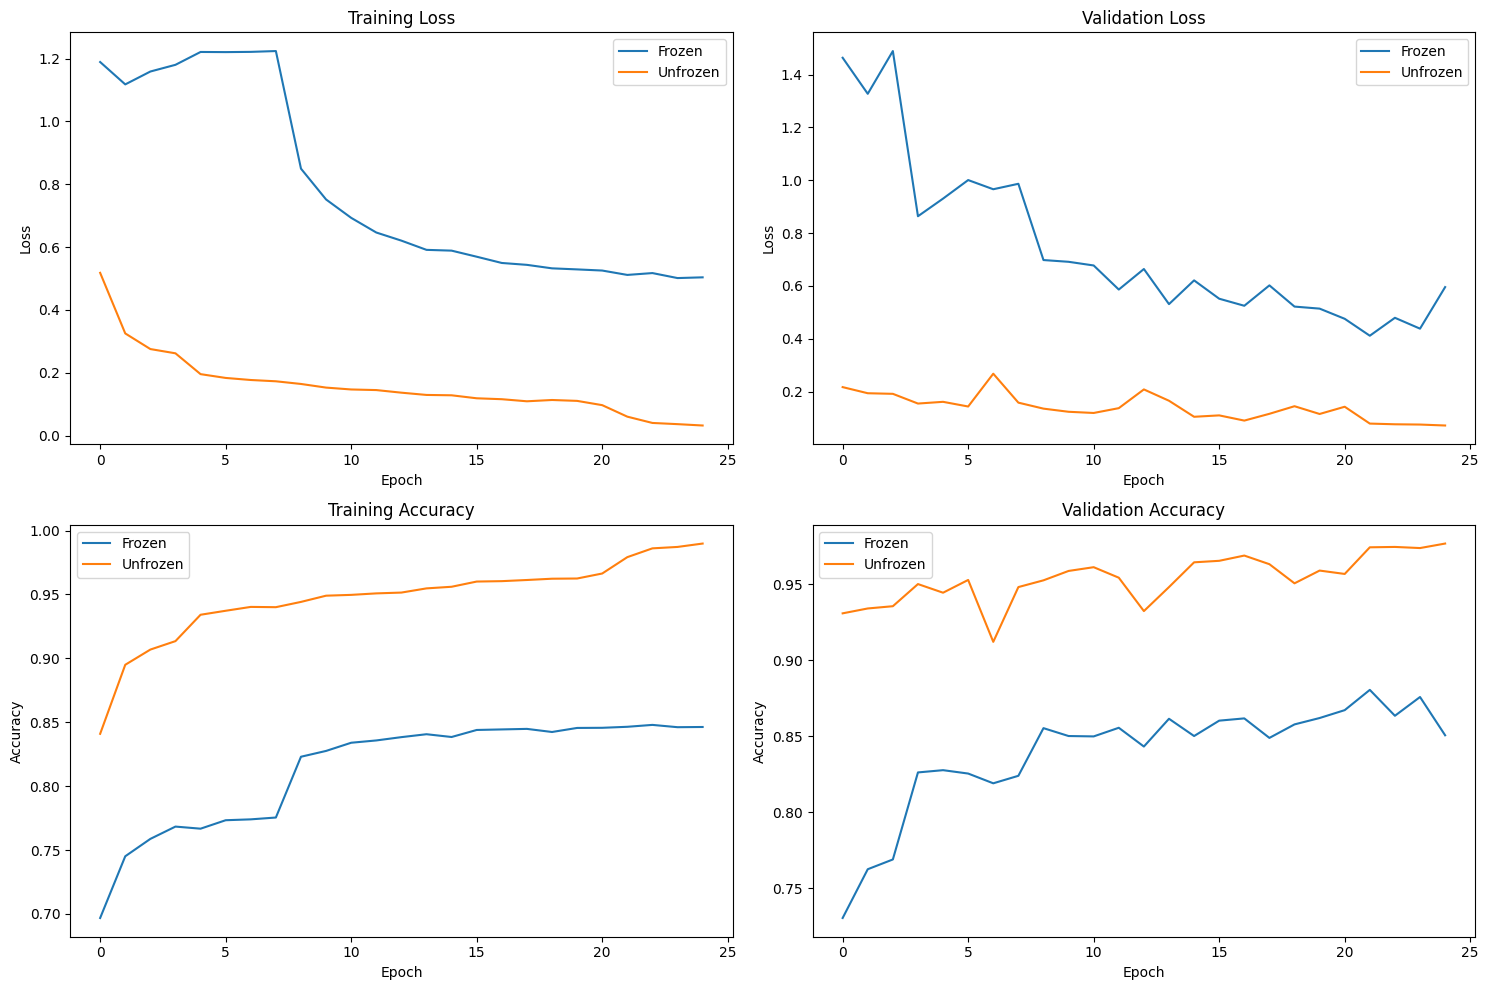


Performance Metrics:


,Metric,Frozen,Unfrozen
0,Best Validation Accuracy,0.8805,0.9768
1,Test Accuracy,0.8370,0.9753
2,Epochs Completed,25.0,25.0


In [11]:
# Compare model architectures
if not df_results.empty and 'model_name' in df_results.columns:
    compare_models_by_architecture()


=== Explore Individual Models ===


Dropdown(description='Select Model:', layout=Layout(width='70%'), options=(('efficientnet_b0_frozen.pth', 0), …

Select a model from the dropdown to view details


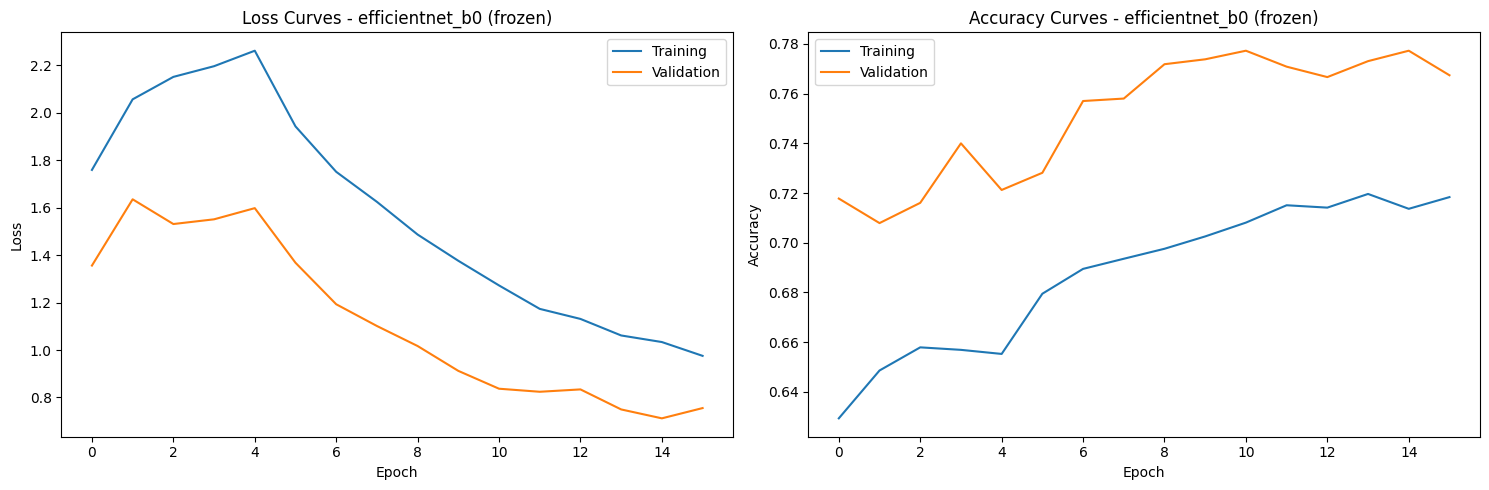

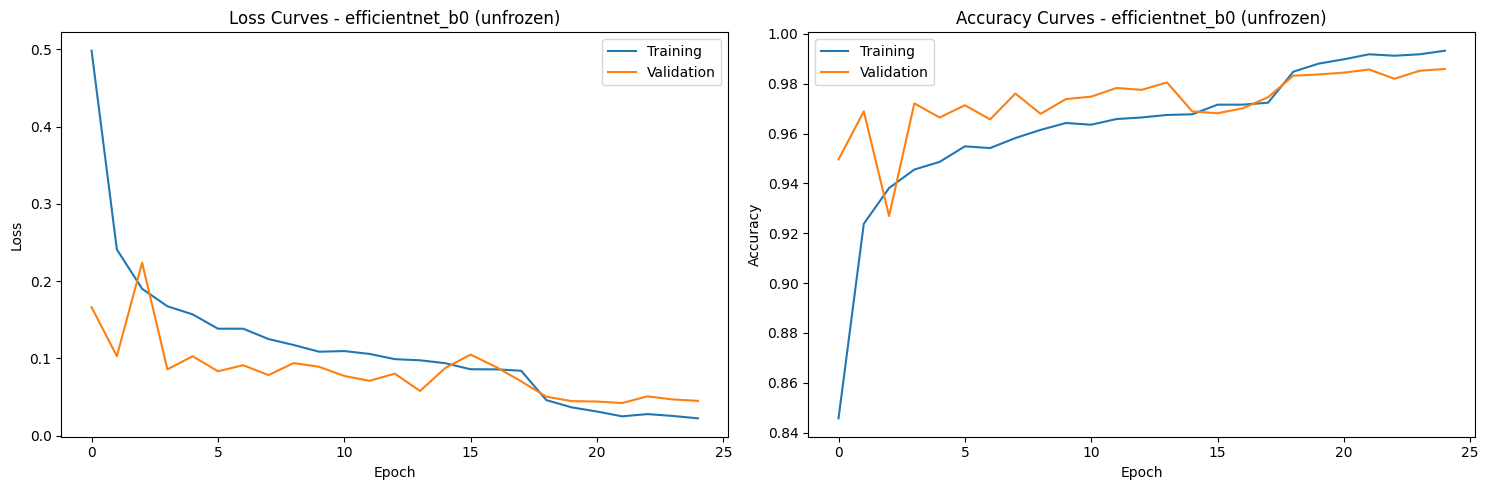

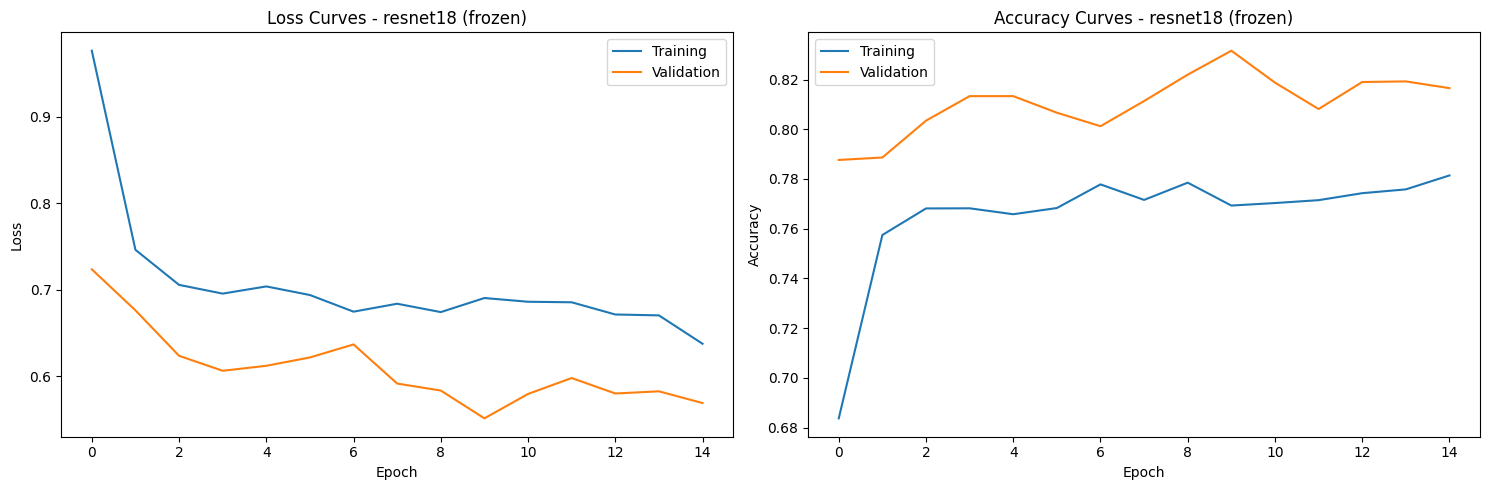

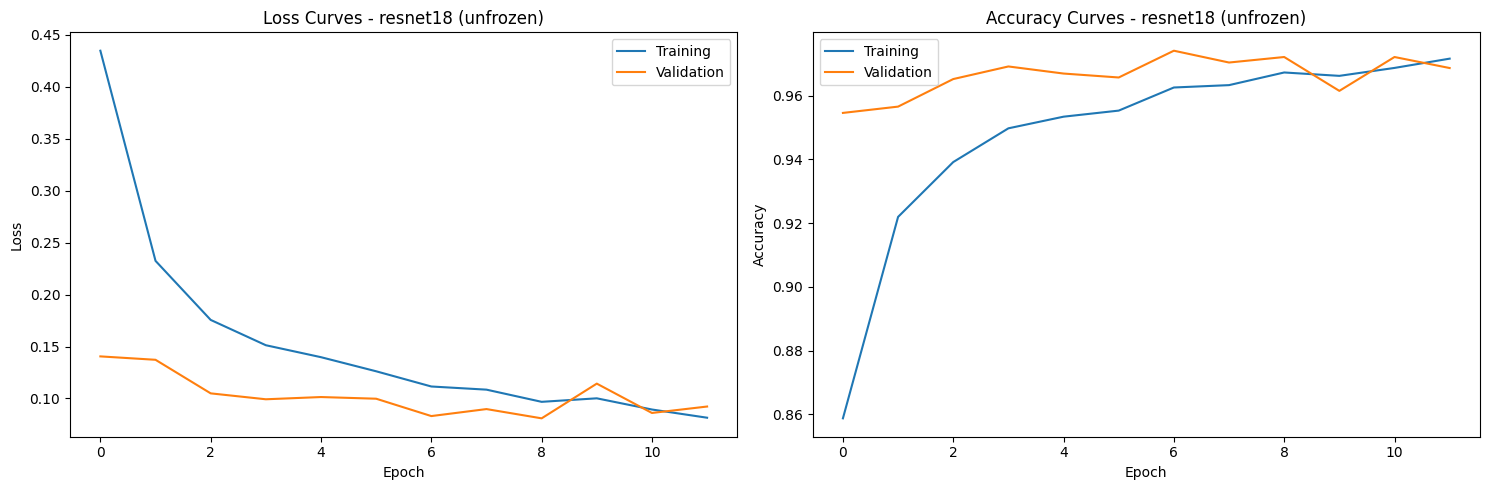

In [12]:
# Create interactive model selector
if not df_results.empty:
    def on_model_selected(change):
        if change['type'] == 'change' and change['new'] is not None:
            try:
                # Get the selected model index - convert to int if needed
                selected_idx = int(change['new']) if isinstance(change['new'], str) else change['new']
                selected_model = model_results[selected_idx]
                
                # Display model details
                print(f"\n=== {selected_model['filename']} ===")
                print(f"Model: {selected_model.get('model_name', 'Unknown')}")
                print(f"Backbone: {selected_model.get('backbone_status', 'Unknown')}")
                
                # Show test accuracy if available
                if 'test_accuracy' in selected_model and selected_model['test_accuracy'] is not None:
                    print(f"Test Accuracy: {selected_model['test_accuracy']:.4f}")
                else:
                    print("Test Accuracy: Not available")
                
                # Plot training history
                plot_model_history(selected_model)
            except (IndexError, ValueError, TypeError) as e:
                print(f"Error displaying model: {e}")
    
    # Create a simpler dropdown format that displays filenames properly
    model_dropdown = widgets.Dropdown(
        options=[(m['filename'], i) for i, m in enumerate(model_results)],
        description='Select Model:',
        style={'description_width': 'initial'},
        layout={'width': '70%'}
    )
    
    # Register callback
    model_dropdown.observe(on_model_selected, names='value')
    
    # Show the dropdown
    print("\n=== Explore Individual Models ===")
    display(model_dropdown)
    print("Select a model from the dropdown to view details")
else:
    print("No models available for interactive exploration")

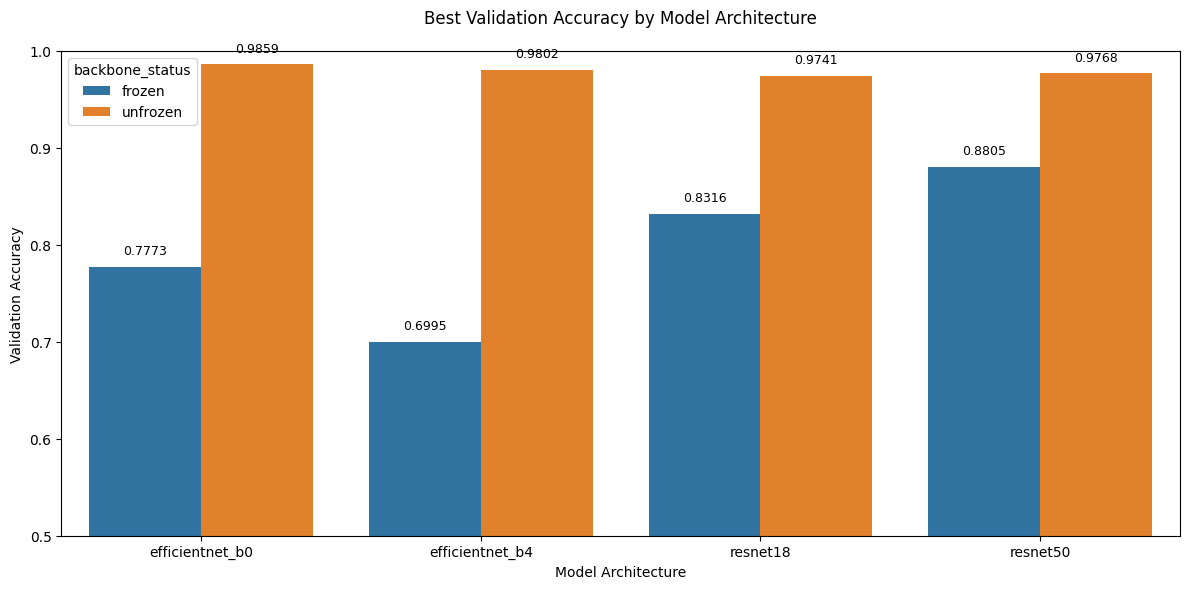

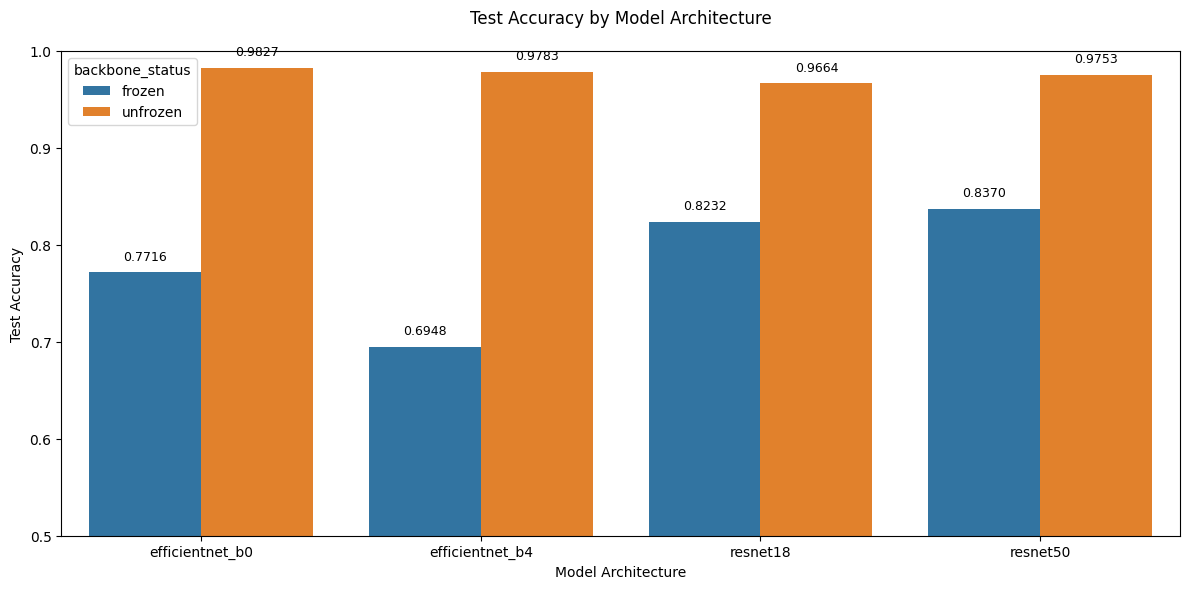

In [13]:
# Plot comparison of model architectures
if not df_results.empty and 'model_name' in df_results.columns and 'best_val_acc' in df_results.columns:
    # Filter out rows with NaN in best_val_acc
    filtered_df = df_results.dropna(subset=['best_val_acc'])
    
    if not filtered_df.empty and len(filtered_df) > 1:
        # Get best model of each type (by validation accuracy)
        best_models = filtered_df.loc[filtered_df.groupby(['model_name', 'backbone_status'])['best_val_acc'].idxmax()]
        
        if len(best_models) > 1:
            plt.figure(figsize=(12, 6))
            
            # Create a grouped bar chart
            ax = sns.barplot(x='model_name', y='best_val_acc', hue='backbone_status', data=best_models)
            
            plt.title('Best Validation Accuracy by Model Architecture', pad=20)  # Add padding to the title
            plt.xlabel('Model Architecture')
            plt.ylabel('Validation Accuracy')
            plt.ylim(0.5, 1.0)  # Adjust as needed
            
            # Add value labels with adjusted position
            for p in ax.patches:
                height = p.get_height()
                # Add a little more vertical space between bar top and text
                ax.annotate(f"{height:.4f}", 
                            (p.get_x() + p.get_width() / 2., height),
                            ha = 'center', va = 'bottom',
                            xytext = (0, 7), textcoords = 'offset points',
                            fontsize=9)  # Slightly smaller font for labels

            
            plt.tight_layout()
            plt.show()
            
            # If test accuracy is available, plot that too
            if 'test_accuracy' in best_models.columns and best_models['test_accuracy'].notna().any():
                # Filter out models with NaN test accuracy
                test_models = best_models.dropna(subset=['test_accuracy'])
                
                if len(test_models) > 1:
                    plt.figure(figsize=(12, 6))
                    
                    ax = sns.barplot(x='model_name', y='test_accuracy', hue='backbone_status', data=test_models)
                    
                    plt.title('Test Accuracy by Model Architecture', pad=20)  # Add padding to the title
                    plt.xlabel('Model Architecture')
                    plt.ylabel('Test Accuracy')
                    plt.ylim(0.5, 1.0)  # Adjust as needed
                    
                    # Add value labels with adjusted position
                    for p in ax.patches:
                        if not np.isnan(p.get_height()):
                            ax.annotate(f"{p.get_height():.4f}", 
                                        (p.get_x() + p.get_width() / 2., p.get_height()),
                                        ha = 'center', va = 'bottom',
                                        xytext = (0, 7), textcoords = 'offset points',
                                        fontsize=9)  # Slightly smaller font for labels
                    
                    plt.tight_layout()
                    plt.show()
        else:
            print("Not enough models with validation accuracy data for comparison")
    else:
        print("Not enough models with validation accuracy data for comparison")